In [1]:
R.Version()

$platform
[1] "x86_64-w64-mingw32"

$arch
[1] "x86_64"

$os
[1] "mingw32"

$system
[1] "x86_64, mingw32"

$status
[1] ""

$major
[1] "4"

$minor
[1] "1.3"

$year
[1] "2022"

$month
[1] "03"

$day
[1] "10"

$`svn rev`
[1] "81868"

$language
[1] "R"

$version.string
[1] "R version 4.1.3 (2022-03-10)"

$nickname
[1] "One Push-Up"

In [2]:
 Sys.setenv(JAGS_HOME = "C:/Program Files/JAGS/JAGS-4.0.0")

In [3]:
.libPaths("C:/Users/jkmer/anaconda3/envs/r4-base/Library")

load.lib <- c("lme4",
              "ggplot2",
              "ggpubr",
              "directlabels",
              "RColorBrewer",
              "ggeffects",
              "see",
              "ggforce",
              "yarrr",
              "mgcv",
              "gratia",
              "tidymv",
              "visreg",
              "tidyverse",
              "dplyr",
              "directlabels",
              "confintr",
              "Kendall",
              "poolr",
              "broom",
              "modelr",
              "gdata",
             "LongituRF",
             "janitor",
             "zoo",
             "gt",
             "scales",
             "glue",
             "purrr",
             "htree",
             "JMbayes",
             "car",
             "agricolae",
             "flextable",
             "crul",
             "rempsyc"
) 

sapply(load.lib,require,character=TRUE)

Loading required package: lme4

Loading required package: Matrix

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: directlabels

Loading required package: RColorBrewer

Loading required package: ggeffects

Loading required package: see

Loading required package: ggforce

Loading required package: yarrr

Loading required package: jpeg

Loading required package: BayesFactor

Loading required package: coda

************
Welcome to BayesFactor 0.9.12-4.4. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Loading required package: circlize

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014

lme4      ggplot2       ggpubr directlabels RColorBrewer    ggeffects 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
         see      ggforce        yarrr         mgcv       gratia       tidymv 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
      visreg    tidyverse        dplyr directlabels     confintr      Kendall 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
       poolr        broom       modelr        gdata    LongituRF      janitor 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
         zoo           gt       scales         glue        purrr        htree 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
     JMbayes          car    agricolae    flextable         crul      rempsyc 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE

In [4]:
# read in cleaned CLinical Severity Scores from Rett Natural History Study 5201 and 5211
clean <- read.csv('C:/Users/jkmer/Desktop/2023_css/20230201_CSS_5201_5211_cleaned.csv')

In [5]:
# prepare compiled data set

In [6]:
mean_pred <- read.csv("C:/Users/jkmer/Desktop/2023_css/mean_pred.csv")
individual_percentiles <- read.csv("C:/Users/jkmer/Desktop/2023_css/percentiles.csv")
xi <- read.csv('C:/Users/jkmer/desktop/2023_css/2023_xi.csv')

In [7]:
baseline <- clean %>% group_by(participant_id) %>% slice(which.min(age_at_visit)) %>% ungroup

In [8]:
baseline <- baseline %>% select(participant_id, 
                                childs_gender, 
                                diagnosis,
                                grouping3,
                                age_at_visit,
                                total_score_clean)

In [9]:
colnames(baseline) <- c('participant_id',
                        'childs_gender',
                        'diagnosis',
                        'grouping3',
                        'baseline_age',
                        'baseline_css')

In [10]:
merged <- merge(x = baseline, y = individual_percentiles %>% select(-grouping3), by="participant_id")

In [11]:
merged2 <- merge(x = merged, y = xi %>% select(c(participant_id, Paternal.Inactivation)), by = "participant_id", all.x = TRUE)

In [12]:
write.csv(merged2, "C:/Users/jkmer/Desktop/2023_css/consensus_data.csv", row.names = FALSE)

## XCI for all diagnosis

In [13]:
#select pertinant columns
xi_analysis <- merged2 %>% drop_na(Paternal.Inactivation)

In [14]:
filteredxi <- xi_analysis

## Nearest age CSS vs XCI

In [15]:
stderror <- function(x) sd(x)/sqrt(length(x))

[1] 9.729302

[1] 198  14

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2


	Pearson's product-moment correlation

data:  corr_df$total_score_clean and corr_df$Paternal.Inactivation
t = 1.044, df = 196, p-value = 0.2978
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.06575794  0.21161256
sample estimates:
       cor 
0.07436543 


[1] 132


	Pearson's product-moment correlation

data:  corr_df$total_score_clean and corr_df$Paternal.Inactivation
t = -1.9388, df = 130, p-value = 0.05469
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.329084892  0.003328741
sample estimates:
       cor 
-0.1676391 


[1] 66


	Pearson's product-moment correlation

data:  corr_df$total_score_clean and corr_df$Paternal.Inactivation
t = 1.6519, df = 64, p-value = 0.1034
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.04185712  0.42352759
sample estimates:
      cor 
0.2022243 


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'


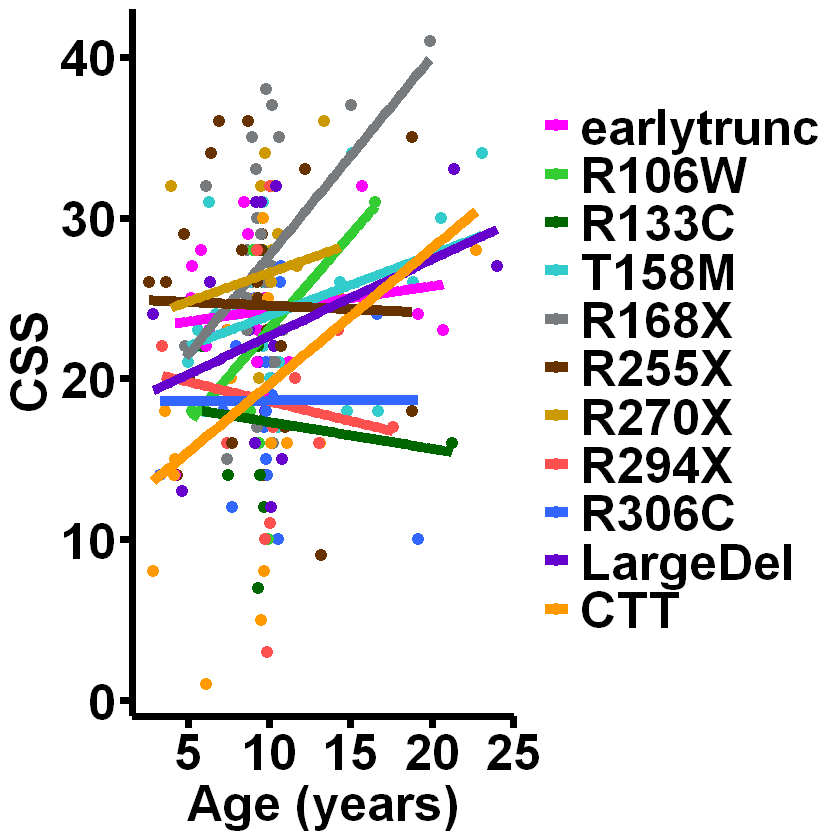

`geom_smooth()` using formula = 'y ~ x'


png 
  2

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'


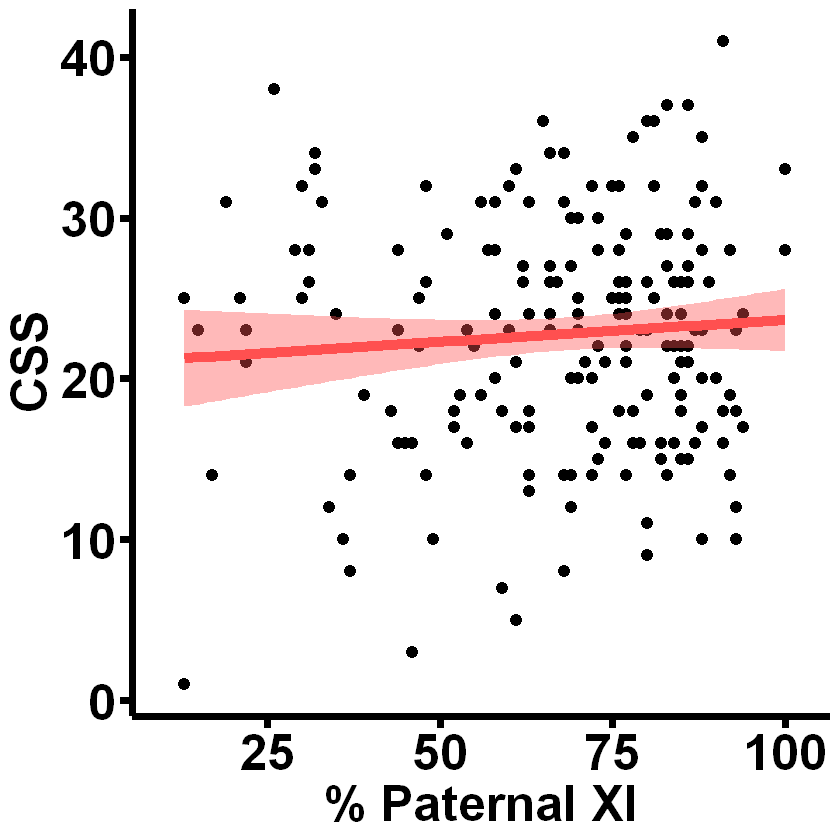

`geom_smooth()` using formula = 'y ~ x'


png 
  2

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'


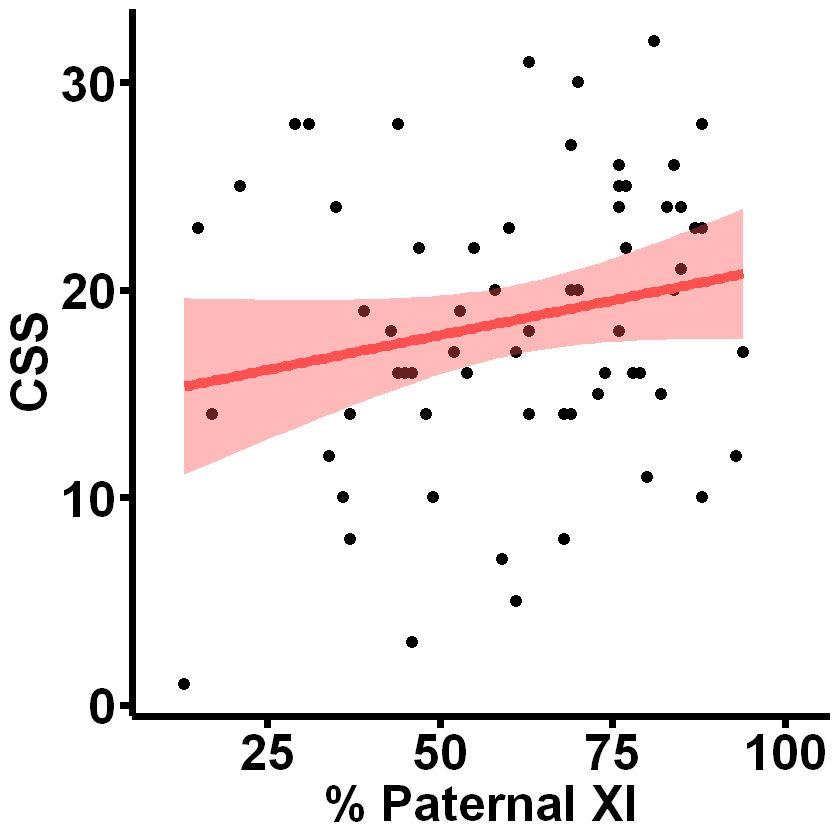

`geom_smooth()` using formula = 'y ~ x'


png 
  2

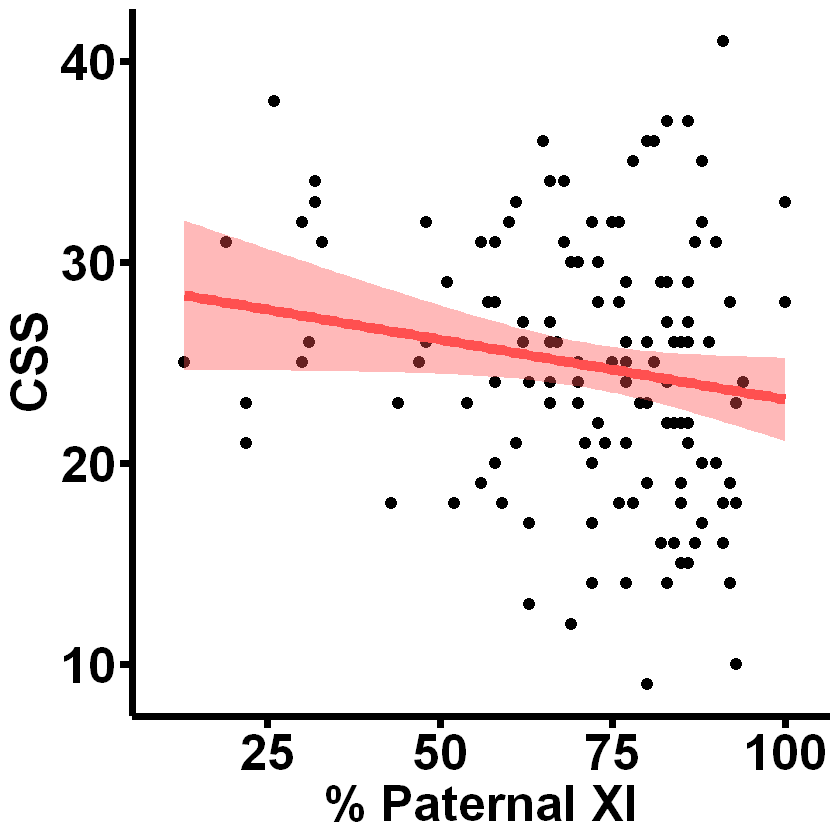

In [16]:
#calc mean age of entire set (not baseline age, to get nearest age to mean)
raw_css <- clean %>% select(participant_id, age_at_visit, total_score_clean)
raw_xi_css <- merge(filteredxi, raw_css, by = 'participant_id')
raw_xi_css <- raw_xi_css %>% group_by(grouping3) %>% 
                    mutate(mean_age = mean(age_at_visit)) %>%
                    mutate(sem = stderror(age_at_visit)) %>% ungroup()
ref_age <- mean(raw_xi_css$age_at_visit)
ref_age
#make column of absolute distance from mean age per observation
raw_xi_css$ref_age_dist <- abs(raw_xi_css$age_at_visit - ref_age)
#group by participant and filter for which minimum distance
nearest_xi_css <- raw_xi_css %>% group_by(participant_id) %>% slice(which.min(ref_age_dist))
#nearest_xi_css <- raw_xi_css %>% group_by(participant_id) %>% slice(which.max(age_at_visit))
dim(nearest_xi_css)

###################################
#define severity groupings
nearest_xi_css <- nearest_xi_css %>%   mutate(sev_group = case_when(
  grouping3 == 'R106W' ~ 1,
  grouping3 == 'T158M' ~ 1,
  grouping3 == 'R133C' ~ 0,  
  grouping3 == 'R168X' ~ 1,
  grouping3 == 'R255X' ~ 1,
  grouping3 == 'R270X' ~ 1,
  grouping3 == 'R294X' ~ 0,
  grouping3 == 'R306C' ~ 0,
  grouping3 == 'CTT' ~ 0,
  grouping3 == 'earlytrunc' ~ 1,
  grouping3 == 'LargeDel' ~ 1))

#plot css nearest this age by mecp2 mutation
testpal <- c('#ff00ff', '#33cc33', '#006600',
             '#33cccc', '#777b7e', '#663300',
             '#cc9900', '#ff5050', '#3366ff',
             '#6600cc', '#ff9900')

My_Theme = theme(
  axis.title.x = element_text(size = 30, face="bold", color = "black"),
  axis.text.x = element_text(size = 30, face="bold", color = "black"),
  axis.title.y = element_text(size = 30, face="bold", color = "black"),
  axis.text.y = element_text(size = 30, face="bold", color = "black"),  
  axis.line=element_line(size = 2, color = "black"),
  axis.ticks = element_line(size = 2, color = "black"),
  legend.text = element_text(size = 30, face = "bold", color = "black"),
  axis.ticks.length=unit(0.1,"inch"),    
  legend.title = element_blank())

nearest_xi_css$grouping3 <- factor(nearest_xi_css$grouping3, levels = c("earlytrunc",
                                 "R106W",
                                 "R133C",
                                 "T158M",
                                 "R168X",
                                 "R255X",
                                 "R270X",
                                 "R294X",
                                 "R306C",
                                 "LargeDel",
                                 "CTT")) 
sp_age <- nearest_xi_css %>%
ggplot(aes(x = age_at_visit, y = total_score_clean, color = grouping3)) +
geom_point(size = 3) + geom_smooth(method="lm", size = 3, se = FALSE) + 
theme_classic() + My_Theme + scale_color_manual(values = testpal) +
ylab('CSS') + xlab('Age (years)')

sp_age

png(file="C:/Users/jkmer/Desktop/2023_css/raw_nearestcss_age.png",
units="in", width=10, height=8, res=300)
sp_age
dev.off()

#run pearsons
#xi corr with severity for all
myvars3 <- c("total_score_clean", "Paternal.Inactivation")
corr_df <- nearest_xi_css[myvars3]
cor.test(corr_df$total_score_clean, corr_df$Paternal.Inactivation)

#xi corr with severity for severe and mild
severe <- c('T158M', 'R168X', 'R255X', 'R270X', 'R106W', 'earlytrunc', 'LargeDel')
myvars3 <- c("total_score_clean", "Paternal.Inactivation")
sevxi <- nearest_xi_css %>% filter(grouping3 %in% severe)
length(unique(sevxi$participant_id))
corr_df <- sevxi[myvars3]
cor.test(corr_df$total_score_clean, corr_df$Paternal.Inactivation)

mild <- c('R133C', 'R306C', 'R294X', 'CTT')
myvars3 <- c("total_score_clean", "Paternal.Inactivation")
mildxi <- nearest_xi_css %>% filter(grouping3 %in% mild)
length(unique(mildxi$participant_id))
corr_df <- mildxi[myvars3]
cor.test(corr_df$total_score_clean, corr_df$Paternal.Inactivation)


#plot xci versus css at this age
My_Theme = theme(
  axis.title.x = element_text(size = 30, face="bold", color = "black"),
  axis.text.x = element_text(size = 30, face="bold", color = "black"),
  axis.title.y = element_text(size = 30, face="bold", color = "black"),
  axis.text.y = element_text(size = 30, face="bold", color = "black"),  
  axis.line=element_line(size = 2, color = "black"),
  axis.ticks = element_line(size = 2, color = "black"),
  axis.ticks.length=unit(0.1,"inch"),  
  legend.position = "none")




sp <- nearest_xi_css %>% 
ggplot(aes(x = Paternal.Inactivation, y = total_score_clean)) +
geom_point(size = 3) + geom_smooth(method="lm", size = 3, fill = '#ff5050', color = '#ff5050') + 
theme_classic()


xiplot <- sp +
My_Theme +
ylab("CSS") +
xlab("% Paternal XI") +  
scale_x_continuous(breaks = c(25, 50, 75, 100)) + xlim(10,102)

xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/raw_xiplot_allmut.png",
units="in", width=8, height=8, res=300)
xiplot
dev.off()

################
#for mild
sp <- nearest_xi_css %>% filter(sev_group == 0) %>%
ggplot(aes(x = Paternal.Inactivation, y = total_score_clean)) +
geom_point(size = 3) + geom_smooth(method="lm", size = 3, fill = '#ff5050', color = '#ff5050') + 
theme_classic()


xiplot <- sp +
My_Theme +
ylab("CSS") +
xlab("% Paternal XI") +  
scale_x_continuous(breaks = c(25, 50, 75, 100)) + xlim(10,102)


xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/raw_xiplot_allmut_mild.png",
units="in", width=8, height=8, res=300)
xiplot
dev.off()


#####################
#for severe
sp <- nearest_xi_css %>% filter(sev_group == 1) %>%
ggplot(aes(x = Paternal.Inactivation, y = total_score_clean)) +
geom_point(size = 3) + geom_smooth(method="lm", size = 3, fill = '#ff5050', color = '#ff5050') + 
theme_classic()


xiplot <- sp +
My_Theme +
ylab("CSS") +
xlab("% Paternal XI") +  
scale_x_continuous(breaks = c(25, 50, 75, 100)) + xlim(10,102)


xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/raw_xiplot_allmut_severe.png",
units="in", width=8, height=8, res=300)
xiplot
dev.off()



In [17]:
dim(nearest_xi_css %>% select(participant_id) %>% unique())

dim(nearest_xi_css %>% filter(sev_group == 0) %>% select(participant_id) %>% unique())

dim(nearest_xi_css %>% filter(sev_group == 1) %>% select(participant_id) %>% unique())

table(nearest_xi_css$grouping3)

[1] 198   1

[1] 66  1

[1] 132   1


earlytrunc      R106W      R133C      T158M      R168X      R255X      R270X 
        17          8         10         26         25         24         14 
     R294X      R306C   LargeDel        CTT 
        16         19         18         21 

## Normative CSS vs XCI

In [18]:
#xi corr with severity for all
myvars3 <- c("Percentile", "Paternal.Inactivation")
corr_df <- filteredxi[myvars3]
ci_cor(corr_df, method = c("pearson"))
cor.test(corr_df$Percentile, corr_df$Paternal.Inactivation)


	Two-sided 95% normal confidence interval for the true Pearson
	correlation coefficient

Sample estimate: -0.07254271 
Confidence interval:
      2.5%      97.5% 
-0.2098613  0.0675824 



	Pearson's product-moment correlation

data:  corr_df$Percentile and corr_df$Paternal.Inactivation
t = -1.0183, df = 196, p-value = 0.3098
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2098613  0.0675824
sample estimates:
        cor 
-0.07254271 


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

`geom_smooth()` using formula = 'y ~ x'


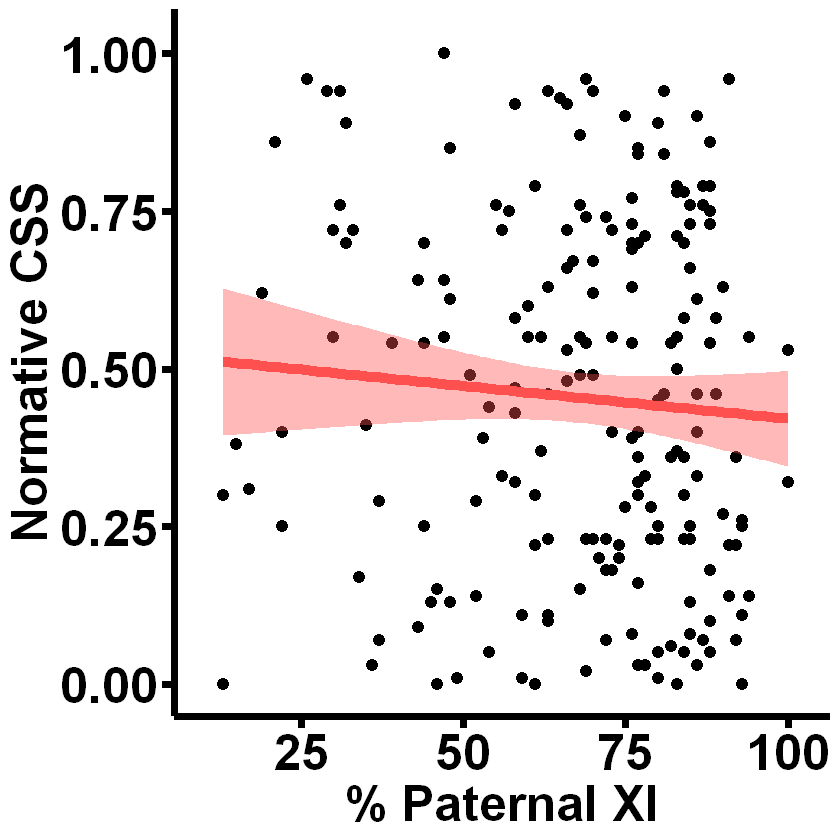

`geom_smooth()` using formula = 'y ~ x'


png 
  2

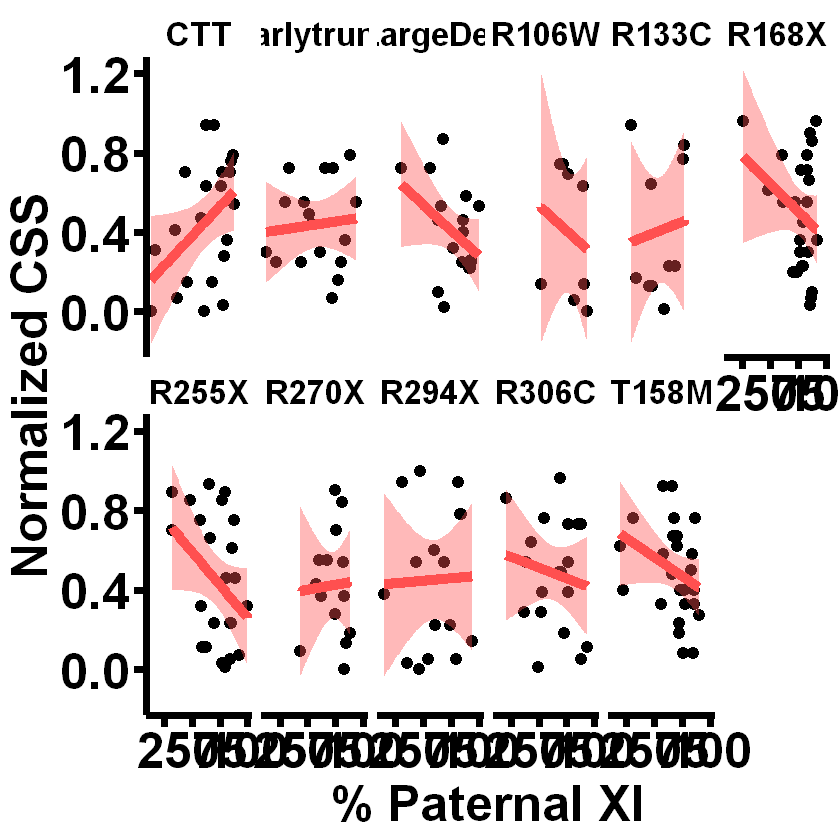

In [19]:
#plot for all

My_Theme = theme(
  axis.title.x = element_text(size = 30, face="bold", color = "black"),
  axis.text.x = element_text(size = 30, face="bold", color = "black"),
  axis.title.y = element_text(size = 30, face="bold", color = "black"),
  axis.text.y = element_text(size = 30, face="bold", color = "black"),  
  axis.line=element_line(size = 2, color = "black"),
  axis.ticks = element_line(size = 2, color = "black"),
  axis.ticks.length=unit(0.1,"inch"),  
  legend.position = "none")

level_order <- c("earlytrunc",
                                 "R106W",
                                 "R133C",
                                 "T158M",
                                 "R168X",
                                 "R255X",
                                 "R270X",
                                 "R294X",
                                 "R306C",
                                 "LargeDel",
                                 "CTT") 


sp <- filteredxi %>%
mutate(norm = Percentile) %>%
ggplot(aes(x = Paternal.Inactivation, y = norm)) +
geom_point(size = 3) + geom_smooth(method="lm", size = 3, fill = '#ff5050', color = '#ff5050') + 
theme_classic()



xiplot <- sp +
My_Theme +
ylab("Normative CSS") +
xlab("% Paternal XI") +
scale_x_continuous(breaks = c(25, 50, 75, 100)) +  xlim(10,102) + ylim(0,1.02)




group_xiplot <- sp + facet_wrap("grouping3", nrow = 2)  +
theme(
  strip.background = element_blank(),
  strip.text.x = element_text(size = 20, face="bold", color = "black")) +
My_Theme  +
ylab("Normalized CSS") +
xlab("% Paternal XI") +
scale_x_continuous(breaks = c(25, 50, 75, 100))

xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/xiplot_allmut_nolabel.png",
units="in", width=8, height=8, res=300)
xiplot
dev.off()

group_xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/group_xiplot.png",
units="in", width=15, height=10, res=300)
group_xiplot
dev.off()



In [20]:
#xi corr with severity for severe and mild
severe <- c('T158M', 'R168X', 'R255X', 'R270X', 'R106W', 'earlytrunc', 'LargeDel')
myvars3 <- c("Percentile", "Paternal.Inactivation")
sevxi <- filteredxi %>% filter(grouping3 %in% severe) %>% filter(Paternal.Inactivation >= 0)
length((sevxi$participant_id))
corr_df <- sevxi[myvars3]
ci_cor(corr_df, method = c("pearson"))
cor.test(corr_df$Percentile, corr_df$Paternal.Inactivation)

[1] 132


	Two-sided 95% normal confidence interval for the true Pearson
	correlation coefficient

Sample estimate: -0.2147746 
Confidence interval:
       2.5%       97.5% 
-0.37199520 -0.04557474 



	Pearson's product-moment correlation

data:  corr_df$Percentile and corr_df$Paternal.Inactivation
t = -2.5073, df = 130, p-value = 0.0134
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.37199520 -0.04557474
sample estimates:
       cor 
-0.2147746 


In [21]:
mild <- c('R133C', 'R306C', 'R294X', 'CTT')
myvars3 <- c("Percentile", "Paternal.Inactivation")
mildxi <- filteredxi %>% filter(grouping3 %in% mild) %>% filter(Paternal.Inactivation >= 0)
length((mildxi$participant_id))
corr_df <- mildxi[myvars3]
ci_cor(corr_df, method = c("pearson"))
cor.test(corr_df$Percentile, corr_df$Paternal.Inactivation)

[1] 66


	Two-sided 95% normal confidence interval for the true Pearson
	correlation coefficient

Sample estimate: 0.1393307 
Confidence interval:
      2.5%      97.5% 
-0.1062863  0.3689225 



	Pearson's product-moment correlation

data:  corr_df$Percentile and corr_df$Paternal.Inactivation
t = 1.1256, df = 64, p-value = 0.2645
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1062863  0.3689225
sample estimates:
      cor 
0.1393307 


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

`geom_smooth()` using formula = 'y ~ x'


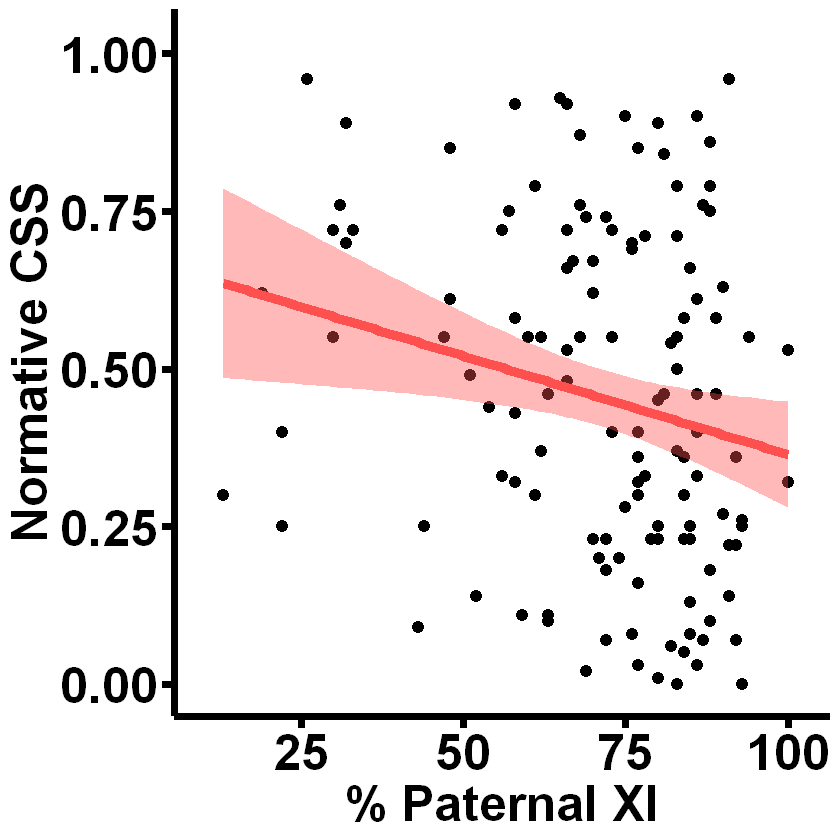

`geom_smooth()` using formula = 'y ~ x'


png 
  2

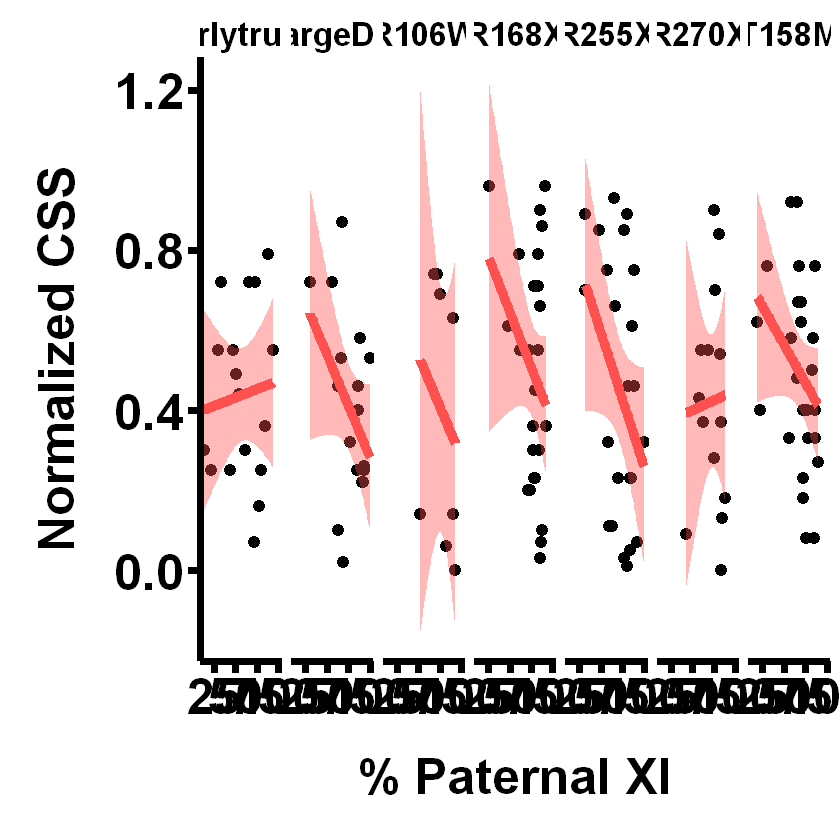

In [22]:
#plot for severe genotypes only
severe <- c('T158M', 'R168X', 'R255X', 'R270X', 'R106W', 'earlytrunc', 'LargeDel')


sp <- filteredxi %>% filter(grouping3 %in% severe) %>%
mutate(norm = Percentile) %>%
ggplot(aes(x = Paternal.Inactivation, y = norm)) +
geom_point(size = 3) + geom_smooth(method="lm", size = 3, fill = '#ff5050', color = '#ff5050') + 
theme_classic()


severe_xiplot <- sp + My_Theme  +
ylab("Normative CSS") +
xlab("% Paternal XI") +
scale_x_continuous(breaks = c(25, 50, 75, 100))  + xlim(10,102) + ylim(0,1.02)

severe_group_xiplot <- sp + facet_wrap("grouping3", nrow = 1) +
theme(
  strip.background = element_blank(),
  strip.text.x = element_text(size = 20, face="bold", color = "black")) +
My_Theme  +
ylab("Normalized CSS") +
xlab("% Paternal XI") +
scale_x_continuous(breaks = c(25, 50, 75, 100))

severe_xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/sev_xiplot_allmut.png",
units="in", width=8, height=8, res=300)
severe_xiplot
dev.off()

severe_group_xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/sev_group_xiplot.png",
units="in", width=12, height=5, res=300)
severe_group_xiplot
dev.off()

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

`geom_smooth()` using formula = 'y ~ x'


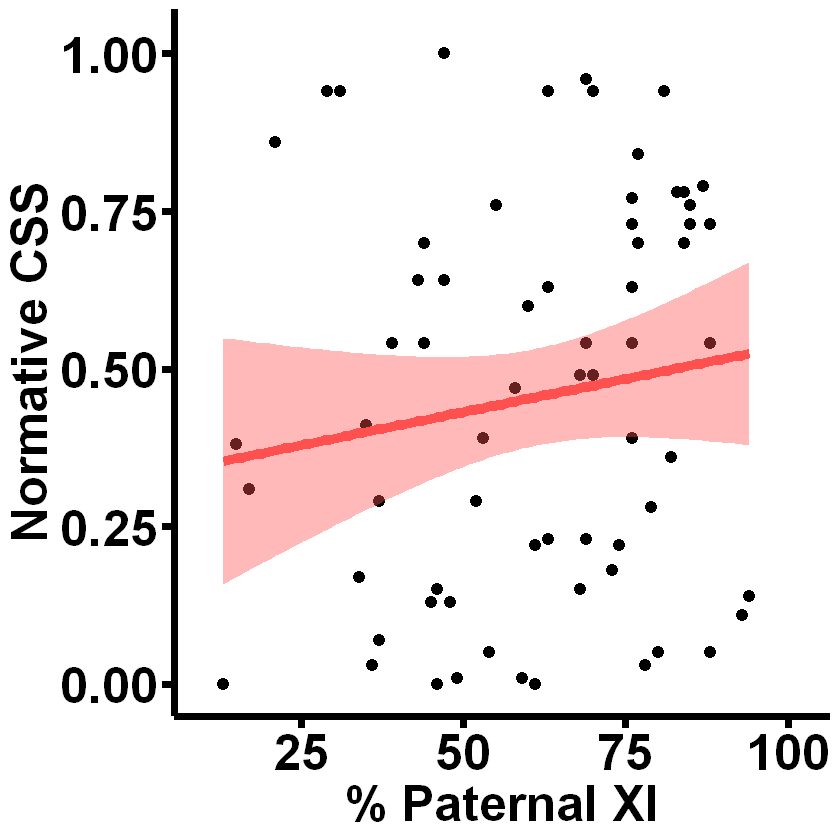

`geom_smooth()` using formula = 'y ~ x'


png 
  2

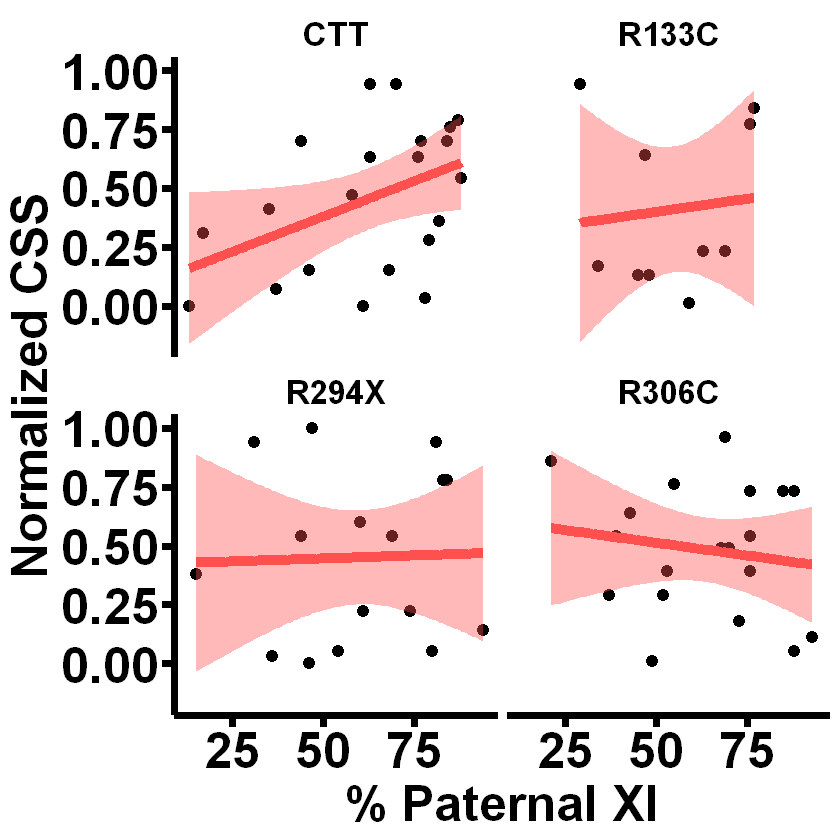

In [23]:
#plot for mild
mild <- c('R133C', 'R306C', 'R294X', 'CTT')

sp <- filteredxi %>% filter(grouping3 %in% mild) %>%
mutate(norm = Percentile) %>%
ggplot(aes(x = Paternal.Inactivation, y = norm)) +
geom_point(size = 3) + geom_smooth(method="lm", size = 3, fill = '#ff5050', color = '#ff5050') + 
theme_classic()




mild_xiplot <- sp +
My_Theme  +
ylab("Normative CSS") +
xlab("% Paternal XI") +
scale_x_continuous(breaks = c(25, 50, 75, 100)) + xlim(10,102) + ylim(0,1.02)

mild_group_xiplot <- sp + facet_wrap("grouping3") +
theme(
  strip.background = element_blank(),
  strip.text.x = element_text(size = 20, face="bold", color = "black")) +
My_Theme  +
ylab("Normalized CSS") +
xlab("% Paternal XI") +
scale_x_continuous(breaks = c(25, 50, 75, 100))

mild_xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/mild_xiplot_allmut.png",
units="in", width=8, height=8, res=300)
mild_xiplot
dev.off()

mild_group_xiplot
png(file="C:/Users/jkmer/Desktop/2023_css/mild_group_xiplot.png",
units="in", width=10, height=5, res=300)
mild_group_xiplot
dev.off()

## Modeling the interaction between MECP2 mutation severity and XCI impact on nCSS

In [24]:
filteredxi <- filteredxi %>%   mutate(sev_group = case_when(
  grouping3 == 'R106W' ~ 1,
  grouping3 == 'T158M' ~ 1,
  grouping3 == 'R133C' ~ 0,  
  grouping3 == 'R168X' ~ 1,
  grouping3 == 'R255X' ~ 1,
  grouping3 == 'R270X' ~ 1,
  grouping3 == 'R294X' ~ 0,
  grouping3 == 'R306C' ~ 0,
  grouping3 == 'CTT' ~ 0,
  grouping3 == 'earlytrunc' ~ 1,
  grouping3 == 'LargeDel' ~ 1))

In [25]:
#build model where ncss is defined by XCI and mecp2 mutation severity group
model_xi <- lm(Percentile ~ Paternal.Inactivation*sev_group, data = filteredxi)

In [26]:
summary(model_xi)


Call:
lm(formula = Percentile ~ Paternal.Inactivation * sev_group, 
    data = filteredxi)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46187 -0.22905 -0.00283  0.22161  0.57436 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)                      0.326801   0.107652   3.036  0.00273 **
Paternal.Inactivation            0.002103   0.001671   1.258  0.20978   
sev_group                        0.349913   0.145541   2.404  0.01715 * 
Paternal.Inactivation:sev_group -0.005225   0.002136  -2.447  0.01531 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2797 on 194 degrees of freedom
Multiple R-squared:  0.0353,	Adjusted R-squared:  0.02038 
F-statistic: 2.366 on 3 and 194 DF,  p-value: 0.07224


In [27]:
# calculate variance explained for xi model
af <- Anova(model_xi, type = 2)
afss <- af$"Sum Sq"
pctvar <- cbind(af,PctExp=(afss/sum(afss))*100)
pctvar$params <- rownames(pctvar)
pctvar

,Sum Sq,Df,F value,Pr(>F),PctExp,params
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Paternal.Inactivation,0.086941007,1,1.11156564,0.29305315,0.55260168,Paternal.Inactivation
sev_group,0.004233371,1,0.05412486,0.81628040,0.02690753,sev_group
Paternal.Inactivation:sev_group,0.468166437,1,5.98564182,0.01531362,2.97569086,Paternal.Inactivation:sev_group
Residuals,15.173692557,194,NA,NA,96.44479992,Residuals
